In [1]:
import pandas as pd

col = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, names=col, encoding='latin-1')
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


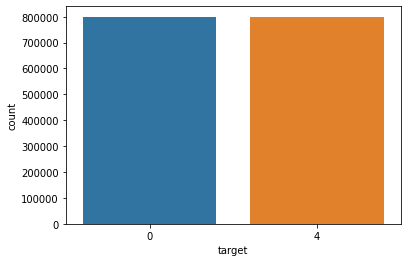

In [2]:
import seaborn as sns

sns.countplot(data=df, x='target');

In [3]:
df = df[['text', 'target']].sample(frac=1)
df['target'].replace(to_replace=4, value=1, inplace=True)
df.head()

,text,target
796903,"@KayBella I have boxes, but I don't think they...",0
519535,How can I still be ill?,0
1048997,@supernova_star - good morning - hope you are...,1
27465,@aashleyyyy I know I know I know and I don't ...,0
819559,@mileycyrus yaaay hope to see you here in whi...,1


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_val_test = train_test_split(df, test_size=20000, random_state=42, stratify=df['target'])
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=42, stratify=df_val_test['target'])

In [5]:
df_train.to_csv('train.csv', index=False)
df_val.to_csv('validation.csv', index=False)
df_test.to_csv('test.csv', index=False)

In [6]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords = set(stopwords)

def preprocess(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    text = text.lower()
    tokens = text.split()
    ps = PorterStemmer()
    tokens = [ps.stem(token) for token in tokens if token not in stopwords]
    
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ahmedessam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df_train.loc[:, 'text'] = df_train['text'].apply(preprocess)
df_val.loc[:, 'text'] = df_val['text'].apply(preprocess)
df_test.loc[:, 'text'] = df_test['text'].apply(preprocess)

/media/ahmedessam/Storage/Codes/Machine Learning/Test/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(max_features=50000, ngram_range=(1, 4))
X_train_vectorized, y_train = tf_idf.fit_transform(df_train.text), df_train.target
X_val_vectorized, y_val = tf_idf.transform(df_val.text), df_val.target

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_classifier = LogisticRegression(random_state=42, verbose=1, n_jobs=-1)
lr_classifier.fit(X_train_vectorized, y_train)
accuracy_score(y_val, lr_classifier.predict(X_val_vectorized))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   32.9s finished


0.792

In [10]:
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(random_state=42, verbose=1, max_iter=2000)
svm_classifier.fit(X_train_vectorized, y_train)
accuracy_score(y_val, svm_classifier.predict(X_val_vectorized))

[LibLinear].....*
optimization finished, #iter = 57
Objective value = -884199.317214
nSV = 1271990


0.7884

In [11]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train_vectorized, y_train)
accuracy_score(y_val, nb_clf.predict(X_val_vectorized))

0.7747

/media/ahmedessam/Storage/Codes/Machine Learning/Test/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        50001     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09517D+06    |proj g|=  6.38911D+03

At iterate   50    f=  7.01366D+05    |proj g|=  9.55720D+02

At iterate  100    f=  6.95920D+05    |proj g|=  3.31664D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
50001    100    119      1     0     0   3.317D+02   6.959D+05
  F =   695919.51085537521     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
